# Air Quality Prediction Study Analysis

This notebook analyzes experimental data from the trust and uncertainty visualization study.
The study examines how different visualization conditions affect user trust, confidence, and decision-making across two phases.

In [420]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import json
import warnings
import math
warnings.filterwarnings('ignore')

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# Set plotting style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Data Loading and Preprocessing

In [421]:
# Load all CSV files from the data directory
data_dir = Path('./data')
csv_files = list(data_dir.glob('user_*.csv'))
print(f"Found {len(csv_files)} participant data files:")
for file in csv_files:
    print(f"  - {file.name}")

Found 59 participant data files:
  - user_616601236834628249_2025-12-08T20-35-30-140.csv
  - user_63480324940301_2025-12-08T20-59-14-576.csv
  - user_593398830001565_2025-12-08T20-47-17-615.csv
  - user_6530681650112025_2025-12-08T21-08-02-359.csv
  - user_67405319336198_2025-12-08T21-49-09-183.csv
  - user_6657381117794993965781_2025-12-08T17-16-29-651.csv
  - user_6434668903503_2025-12-08T21-51-51-161.csv
  - user_597179708680001941493_2025-12-08T21-29-17-324.csv
  - user_6748587090888_2025-12-08T21-14-56-524.csv
  - user_72_2025-12-04T19-11-58-835.csv
  - user_5018800600069479_2025-12-08T20-33-44-483.csv
  - user_666145876998509328_2025-12-08T21-57-30-509.csv
  - user_58675600019312_2025-12-08T18-38-13-701.csv
  - user_6456020553922037_2025-12-08T21-47-19-421.csv
  - user_65580725188_2025-12-08T21-20-04-099.csv
  - user_6691822592819053_2025-12-08T20-47-18-163.csv
  - user_598940754700001015_2025-12-08T17-57-48-359.csv
  - user_54917598062816_2025-12-08T21-47-30-735.csv
  - user_674

In [422]:
# Function to load and clean individual participant data
def load_participant_data(file_path):
    """Load a single participant CSV file and clean the data"""
    try:
        df = pd.read_csv(file_path)
        
        # Extract participant ID from filename if not in data
        if 'participant_id' not in df.columns or df['participant_id'].isna().all():
            participant_id = file_path.stem.split('_')[1]  # Extract from filename
            df['participant_id'] = participant_id
        
        # Clean condition IDs and names
        if 'condition_id' in df.columns:
            df['condition_id'] = df['condition_id'].fillna('unknown')
        
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load all participant data
all_data = []
for file_path in csv_files:
    participant_data = load_participant_data(file_path)
    if participant_data is not None:
        all_data.append(participant_data)
        print(f"Loaded data for participant: {participant_data['participant_id'].iloc[0] if not participant_data['participant_id'].isna().all() else 'unknown'}")

# Combine all participant data
if all_data:
    combined_data = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined dataset shape (before filtering): {combined_data.shape}")
    
    # Filter out test participants
    test_participants = ['test', 'Test', 'TEST']
    before_count = combined_data['participant_id'].nunique()
    combined_data = combined_data[~combined_data['participant_id'].isin(test_participants)]
    combined_data = combined_data[combined_data['participant_id'].notna()]  # Also remove NaN participants
    after_count = combined_data['participant_id'].nunique()
    
    print(f"Filtered out test participants and NaN entries")
    print(f"Participants: {before_count} → {after_count}")
    print(f"Final dataset shape: {combined_data.shape}")
else:
    print("No data loaded successfully")

Loaded data for participant: 6166c0eb123b6e8b34628249
Loaded data for participant: 63480f3ff2ebda4f9403cc01
Loaded data for participant: 59baa339ab8d830001fe56f5
Loaded data for participant: 65d306f8b16eb5011ccb2025
Loaded data for participant: 67dd40b531ab9c33ff61e98e
Loaded data for participant: 66573c811d17794993965781
Loaded data for participant: 643466ccb8e9bb0350af3cbb
Loaded data for participant: 59f71f797086f80001941493
Loaded data for participant: 67ddd4f85ab870ffd90cc888
Loaded data for participant: nan
Loaded data for participant: 5e0e1b8800a6bf000a694f79
Loaded data for participant: 6661bf4587f6b99850d9328b
Loaded data for participant: 58adfc6e7cf56d0001f931a2
Loaded data for participant: 64560bd205fd539c22bc0b37
Loaded data for participant: 65fb580ab7fbb2d518ee8eaa
Loaded data for participant: 669c182b2a59d2c81e9053ad
Loaded data for participant: 5b98940f754b700001f0f15c
Loaded data for participant: 5f4f9bc1f7598f06b2dc816f
Loaded data for participant: 6748f8e31516667cc3eb

In [423]:
# Examine the data structure
print("Column names:")
print(combined_data.columns.tolist())
print(f"\nDataset shape: {combined_data.shape}")
# print(f"\nUnique trial types:")
# print(combined_data['trial_type'].value_counts())

Column names:
['city_a_estimate', 'city_b_estimate', 'click_events', 'comprehension_ease', 'condition', 'condition_id', 'condition_name', 'confidence_label', 'confidence_rating', 'data_trust', 'display_format', 'end_time', 'failed_audio', 'failed_images', 'failed_video', 'hover_events', 'interaction_log', 'internal_node_id', 'participant_id', 'percent_score', 'phase', 'phase1_complete', 'phase2_complete', 'predictions_shown', 'probability_estimate', 'question_order', 'response', 'responses', 'round', 'rt', 'rt_total', 'skeptical_rating', 'slider_moved', 'start_time', 'stimulus', 'success', 'time_elapsed', 'time_on_viz', 'timeout', 'total_interactions', 'total_questions', 'total_score', 'travel_choice', 'trial_index', 'trial_type', 'trust_composite', 'usability_composite', 'usability_difficulty', 'view_history', 'visualization_literacy_score', 'visualization_shown', 'interface_trust', 'misleading_rating', 'trust_adjusted']

Dataset shape: (1078, 54)


In [424]:
# Filter for relevant trial types (prediction tasks and surveys)
relevant_trials = combined_data[
    combined_data['trial_type'].isin([
        'prediction-task', 'vis-literacy', 'trust-survey', 
        'personality-survey', 'survey-text', 'survey-multi-choice'
    ])
].copy()

print(f"Filtered dataset shape: {relevant_trials.shape}")
print(f"\nTrial types in filtered data:")
print(relevant_trials['trial_type'].value_counts())

Filtered dataset shape: (486, 54)

Trial types in filtered data:
trial_type
survey-text            108
prediction-task        108
trust-survey           108
vis-literacy            54
personality-survey      54
survey-multi-choice     54
Name: count, dtype: int64


In [425]:
# Examine condition distribution
print("Unique conditions:")
condition_counts = relevant_trials['condition_id'].value_counts(dropna=False)
print(condition_counts)

print("\nCondition names:")
condition_names = relevant_trials[['condition_id', 'condition_name']].drop_duplicates().dropna()
for _, row in condition_names.iterrows():
    print(f"  {row['condition_id']}: {row['condition_name']}")

Unique conditions:
condition_id
condition_8_bad               91
condition_4_ensemble_hover    63
unknown                       54
condition_0_historical        54
condition_1_baseline          42
condition_7_buggy             35
condition_5_pi_hover          35
condition_9_combined          35
condition_6_pi_to_ensemble    35
condition_3_ensemble          21
condition_2_pi_plot           21
Name: count, dtype: int64

Condition names:
  condition_4_ensemble_hover: Ensemble + Hover
  condition_0_historical: Historical Only
  condition_7_buggy: Buggy Control
  condition_8_bad: Bad Control
  condition_5_pi_hover: PI Plot + Hover
  condition_3_ensemble: Ensemble Plot
  condition_1_baseline: Baseline
  condition_9_combined: Combined PI + Ensemble
  condition_6_pi_to_ensemble: PI → Ensemble
  condition_2_pi_plot: PI Plot


In [426]:
# Separate Phase 1 and Phase 2 data
prediction_data = relevant_trials[relevant_trials['trial_type'] == 'prediction-task'].copy()

# Phase separation logic
phase1_data = prediction_data[prediction_data['phase'] == 1].copy()
phase2_data = prediction_data[prediction_data['phase'] == 2].copy()

print(f"Phase 1 data: {len(phase1_data)} rows")
print(f"Phase 2 data: {len(phase2_data)} rows")

# Get visualization literacy data
vis_literacy_data = relevant_trials[relevant_trials['trial_type'] == 'vis-literacy'].copy()
print(f"Visualization literacy data: {len(vis_literacy_data)} rows")

# Separate different types of survey data

# Get trust-survey data (interface interaction and visualization trust questions)
all_trust_surveys = relevant_trials[relevant_trials['trial_type'] == 'trust-survey'].copy()
print(f"All trust survey data: {len(all_trust_surveys)} rows")

# Get personality survey data (demographics questions)
all_personality_surveys = relevant_trials[relevant_trials['trial_type'] == 'personality-survey'].copy()
print(f"All personality survey data: {len(all_personality_surveys)} rows")

# Function to check if a row represents a specific survey type based on question_order
def get_survey_type(row):
    """Determine survey type based on question_order content"""
    if 'question_order' in row and pd.notna(row['question_order']):
        try:
            question_order = eval(row['question_order'])  # Convert string to list
            if isinstance(question_order, list) and len(question_order) > 0:
                first_question = question_order[0]
                
                # Define the first question of each survey type
                if first_question == 'navigation_control':
                    return 'interaction'
                elif first_question == 'skeptical_rating':
                    return 'trust'
                elif first_question == 'respect_others':
                    return 'demographics'
        except:
            pass
    return 'unknown'

# Add survey type classification to trust surveys
all_trust_surveys['survey_type'] = all_trust_surveys.apply(get_survey_type, axis=1)

# Separate the data based on survey types
interaction_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'interaction'].copy()
trust_data = all_trust_surveys[all_trust_surveys['survey_type'] == 'trust'].copy()
demographics_data = all_personality_surveys.copy()  # Demographics is in personality-survey trial type

print(f"Interaction data: {len(interaction_data)} rows")
print(f"Trust data: {len(trust_data)} rows") 
print(f"Demographics data: {len(demographics_data)} rows")

# Show survey type distribution
print(f"\nTrust survey type distribution:")
print(all_trust_surveys['survey_type'].value_counts())

Phase 1 data: 54 rows
Phase 2 data: 54 rows
Visualization literacy data: 54 rows
All trust survey data: 108 rows
All personality survey data: 54 rows
Interaction data: 54 rows
Trust data: 54 rows
Demographics data: 54 rows

Trust survey type distribution:
survey_type
interaction    54
trust          54
Name: count, dtype: int64


## 2. Basic Statistics Tables by Condition

Each table shows conditions as rows and response variables as columns, with participant response lists in each cell.

In [427]:
def create_condition_response_table(data, response_columns, title="Response Table"):
    """
    Create a table where each row is a condition and each column is a response variable.
    Each cell contains a list of participant responses.
    """
    # Get unique conditions
    conditions = sorted(data['condition_id'].dropna().unique())
    
    # Initialize results dictionary
    results = {}
    
    for condition in conditions:
        condition_data = data[data['condition_id'] == condition]
        condition_responses = {}
        
        for col in response_columns:
            if col in condition_data.columns:
                responses = condition_data[col].dropna().tolist()
                condition_responses[col] = responses
            else:
                condition_responses[col] = []
        
        results[condition] = condition_responses
    
    # Convert to DataFrame
    df = pd.DataFrame(results).T
    
    print(f"\n{title}")
    print("=" * len(title))
    return df

# Function to display response summary statistics
def display_response_summary(df, title="Summary"):
    """
    Display summary statistics for response lists in each cell
    """
    print(f"\n{title} - Response Counts and Basic Stats")
    print("-" * (len(title) + 30))
    
    for condition in df.index:
        print(f"\nCondition: {condition}")
        for col in df.columns:
            responses = df.loc[condition, col]
            if isinstance(responses, list) and responses:
                numeric_responses = [r for r in responses if isinstance(r, (int, float)) and not pd.isna(r)]
                if numeric_responses:
                    print(f"  {col}: n={len(numeric_responses)}, mean={np.mean(numeric_responses):.2f}, responses={numeric_responses}")
                else:
                    print(f"  {col}: n={len(responses)}, responses={responses[:5]}{'...' if len(responses) > 5 else ''}")
            else:
                print(f"  {col}: No responses")
    
    return df

### Phase 1 Responses (Baseline - No Visualization)

In [428]:
# Phase 1 response columns
phase1_columns = ['probability_estimate', 'confidence_rating', 'travel_choice']

# Create Phase 1 table
phase1_table = create_condition_response_table(
    phase1_data, 
    phase1_columns, 
    "Phase 1 Responses (No Visualization)"
)

# Display the table
display_response_summary(phase1_table, "Phase 1 Summary")


Phase 1 Responses (No Visualization)

Phase 1 Summary - Response Counts and Basic Stats
---------------------------------------------

Condition: condition_0_historical
  probability_estimate: n=54, mean=48.52, responses=[8.0, 60.0, 35.0, 80.0, 63.0, 80.0, 92.0, 80.0, 80.0, 14.0, 88.0, 98.0, 84.0, 95.0, 15.0, 0.0, 24.0, 32.0, 35.0, 88.0, 8.0, 38.0, 75.0, 35.0, 35.0, 15.0, 63.0, 23.0, 75.0, 20.0, 50.0, 0.0, 10.0, 76.0, 60.0, 65.0, 46.0, 13.0, 49.0, 11.0, 100.0, 1.0, 70.0, 58.0, 0.0, 28.0, 60.0, 81.0, 60.0, 7.0, 40.0, 82.0, 95.0, 20.0]
  confidence_rating: n=54, mean=4.02, responses=[6.0, 1.0, 5.0, 6.0, 5.0, 5.0, 7.0, 3.0, 5.0, 2.0, 3.0, 5.0, 6.0, 6.0, 2.0, 1.0, 3.0, 3.0, 5.0, 4.0, 1.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0, 2.0, 4.0, 4.0, 5.0, 3.0, 2.0, 5.0, 5.0, 3.0, 3.0, 2.0, 7.0, 5.0, 5.0, 4.0, 5.0, 2.0, 5.0, 3.0, 3.0, 2.0, 5.0, 5.0, 5.0, 2.0]
  travel_choice: n=54, responses=['City A', 'No Preference', 'City A', 'City B', 'City A']...


,probability_estimate,confidence_rating,travel_choice
condition_0_historical,"[8.0, 60.0, 35.0, 80.0, 63.0, 80.0, 92.0, 80.0...","[6.0, 1.0, 5.0, 6.0, 5.0, 5.0, 7.0, 3.0, 5.0, ...","[City A, No Preference, City A, City B, City A..."


### Phase 2 Responses (With Visualization)

In [429]:
# Phase 2 response columns
phase2_columns = ['probability_estimate', 'confidence_rating', 'travel_choice', 'data_trust', 'skeptical_rating']

# Create Phase 2 table
phase2_table = create_condition_response_table(
    phase2_data, 
    phase2_columns, 
    "Phase 2 Responses (With Visualization)"
)

# Display the table
display_response_summary(phase2_table, "Phase 2 Summary")


Phase 2 Responses (With Visualization)

Phase 2 Summary - Response Counts and Basic Stats
---------------------------------------------

Condition: condition_1_baseline
  probability_estimate: n=6, mean=67.17, responses=[29.0, 100.0, 96.0, 10.0, 78.0, 90.0]
  confidence_rating: n=6, mean=3.83, responses=[2.0, 3.0, 6.0, 5.0, 2.0, 5.0]
  travel_choice: n=6, responses=['City B', 'City A', 'City B', 'City B', 'City A']...
  data_trust: No responses
  skeptical_rating: No responses

Condition: condition_2_pi_plot
  probability_estimate: n=3, mean=40.00, responses=[20.0, 0.0, 100.0]
  confidence_rating: n=3, mean=4.67, responses=[5.0, 2.0, 7.0]
  travel_choice: n=3, responses=['City B', 'City A', 'City A']
  data_trust: No responses
  skeptical_rating: No responses

Condition: condition_3_ensemble
  probability_estimate: n=3, mean=63.33, responses=[83.0, 84.0, 23.0]
  confidence_rating: n=3, mean=5.67, responses=[5.0, 7.0, 5.0]
  travel_choice: n=3, responses=['City A', 'City A', 'City B']


,probability_estimate,confidence_rating,travel_choice,data_trust,skeptical_rating
condition_1_baseline,"[29.0, 100.0, 96.0, 10.0, 78.0, 90.0]","[2.0, 3.0, 6.0, 5.0, 2.0, 5.0]","[City B, City A, City B, City B, City A, City A]",[],[]
condition_2_pi_plot,"[20.0, 0.0, 100.0]","[5.0, 2.0, 7.0]","[City B, City A, City A]",[],[]
condition_3_ensemble,"[83.0, 84.0, 23.0]","[5.0, 7.0, 5.0]","[City A, City A, City B]",[],[]
condition_4_ensemble_hover,"[9.0, 90.0, 94.0, 0.0, 63.0, 7.0, 45.0, 6.0, 1...","[6.0, 5.0, 6.0, 1.0, 3.0, 3.0, 4.0, 4.0, 5.0]","[City A, City A, City A, City B, City A, City ...",[],[]
condition_5_pi_hover,"[100.0, 61.0, 86.0, 30.0, 1.0]","[5.0, 5.0, 5.0, 5.0, 5.0]","[City A, City B, City A, City B, City A]",[],[]
condition_6_pi_to_ensemble,"[13.0, 62.0, 15.0, 21.0, 2.0]","[3.0, 4.0, 1.0, 5.0, 2.0]","[City B, City B, City A, City B, City A]",[],[]
condition_7_buggy,"[61.0, 100.0, 80.0, 0.0, 5.0]","[1.0, 6.0, 5.0, 4.0, 5.0]","[No Preference, City A, City A, City A, City B]",[],[]
condition_8_bad,"[15.0, 57.0, 34.0, 75.0, 6.0, 100.0, 63.0, 0.0...","[6.0, 2.0, 5.0, 5.0, 6.0, 5.0, 5.0, 5.0, 2.0, ...","[City A, City A, City B, No Preference, City B...",[],[]
condition_9_combined,"[0.0, 50.0, 30.0, 59.0, 85.0]","[5.0, 4.0, 4.0, 5.0, 6.0]","[City B, City A, City A, City A, City A]",[],[]


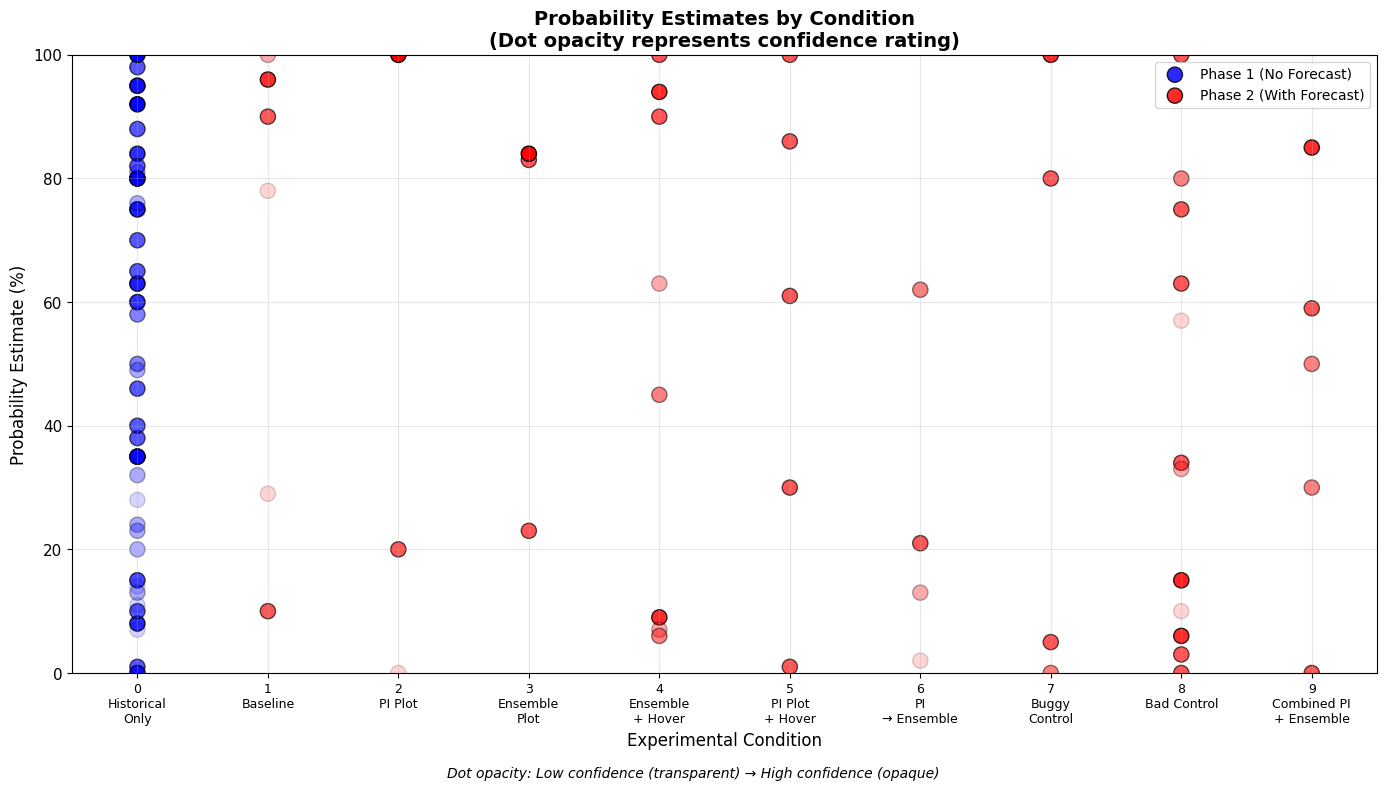


Visualization Data Summary:
Phase 1: 54 data points
Phase 2: 54 data points
Conditions with data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Condition Mapping:
  ✓ Condition 0: Historical Only
  ✓ Condition 1: Baseline
  ✓ Condition 2: PI Plot
  ✓ Condition 3: Ensemble Plot
  ✓ Condition 4: Ensemble + Hover
  ✓ Condition 5: PI Plot + Hover
  ✓ Condition 6: PI → Ensemble
  ✓ Condition 7: Buggy Control
  ✓ Condition 8: Bad Control
  ✓ Condition 9: Combined PI + Ensemble


In [430]:
# Create combined dot plot visualization with probability estimates by condition
# Opacity based on confidence rating

def create_probability_dot_plot():
    """Create a dot plot showing probability estimates by condition with confidence-based opacity"""
    
    # Define condition mapping
    condition_names = {
        0: "Historical Only",
        1: "Baseline", 
        2: "PI Plot",
        3: "Ensemble Plot",
        4: "Ensemble + Hover", 
        5: "PI Plot + Hover",
        6: "PI → Ensemble",
        7: "Buggy Control",
        8: "Bad Control",
        9: "Combined PI + Ensemble"
    }
    
    # Combine Phase 1 and Phase 2 data for visualization
    viz_data = []
    
    # Add Phase 1 data
    for _, row in phase1_data.iterrows():
        if pd.notna(row['probability_estimate']) and pd.notna(row['confidence_rating']):
            viz_data.append({
                'condition_id': row['condition_id'],
                'probability_estimate': row['probability_estimate'],
                'confidence_rating': row['confidence_rating'],
                'phase': 'Phase 1'
            })
    
    # Add Phase 2 data
    for _, row in phase2_data.iterrows():
        if pd.notna(row['probability_estimate']) and pd.notna(row['confidence_rating']):
            viz_data.append({
                'condition_id': row['condition_id'],
                'probability_estimate': row['probability_estimate'],
                'confidence_rating': row['confidence_rating'],
                'phase': 'Phase 2'
            })
    
    if not viz_data:
        print("No data available for visualization")
        return
    
    viz_df = pd.DataFrame(viz_data)
    
    # Extract condition numbers for x-axis ordering
    def extract_condition_number(condition_id):
        if pd.isna(condition_id) or condition_id == 'unknown':
            return -1
        try:
            # Extract number from condition_X_name format
            parts = str(condition_id).split('_')
            if len(parts) >= 2:
                return int(parts[1])
        except:
            pass
        return -1
    
    viz_df['condition_number'] = viz_df['condition_id'].apply(extract_condition_number)
    viz_df = viz_df[viz_df['condition_number'] >= 0]  # Remove unknown conditions
    
    # Normalize confidence rating to 0-1 for opacity (1-7 scale -> 0-1 scale)
    viz_df['opacity'] = (viz_df['confidence_rating'] - 1) / 6  # Convert 1-7 to 0-1
    
    # Create the combined plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Plot Phase 1 and Phase 2 data with different colors
    phase1_viz = viz_df[viz_df['phase'] == 'Phase 1']
    phase2_viz = viz_df[viz_df['phase'] == 'Phase 2']
    
    if len(phase1_viz) > 0:
        ax.scatter(phase1_viz['condition_number'], 
                  phase1_viz['probability_estimate'],
                  alpha=phase1_viz['opacity'],
                  s=120, c='blue', edgecolors='black', linewidth=1,
                  label='Phase 1 (No Forecast)')
    
    if len(phase2_viz) > 0:
        ax.scatter(phase2_viz['condition_number'], 
                  phase2_viz['probability_estimate'],
                  alpha=phase2_viz['opacity'],
                  s=120, c='red', edgecolors='black', linewidth=1,
                  label='Phase 2 (With Forecast)')
    
    # Set up the plot
    ax.set_title('Probability Estimates by Condition\n(Dot opacity represents confidence rating)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Experimental Condition', fontsize=12)
    ax.set_ylabel('Probability Estimate (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3)
    
    # Force x-axis to show all conditions 0-9
    ax.set_xlim(-0.5, 9.5)
    ax.set_xticks(range(10))
    
    # Create condition labels for x-axis
    condition_labels = []
    for i in range(10):
        if i in condition_names:
            # Wrap long names for better display
            name = condition_names[i]
            if len(name) > 12:
                words = name.split()
                if len(words) > 1:
                    mid = len(words) // 2
                    name = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
            condition_labels.append(f"{i}\n{name}")
        else:
            condition_labels.append(f"{i}\n(No Data)")
    
    ax.set_xticklabels(condition_labels, fontsize=9, ha='center')
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)
    
    # Add opacity explanation
    fig.text(0.5, 0.02, 'Dot opacity: Low confidence (transparent) → High confidence (opaque)', 
             ha='center', fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    # Print summary statistics
    print(f"\nVisualization Data Summary:")
    print(f"Phase 1: {len(phase1_viz)} data points")
    print(f"Phase 2: {len(phase2_viz)} data points")
    print(f"Conditions with data: {sorted(viz_df['condition_number'].unique())}")
    
    # Show condition mapping
    print(f"\nCondition Mapping:")
    present_conditions = sorted(viz_df['condition_number'].unique())
    for i in range(10):
        status = "✓" if i in present_conditions else "✗"
        name = condition_names.get(i, "Unknown")
        print(f"  {status} Condition {i}: {name}")
    
    return viz_df

# Create the visualization
viz_summary = create_probability_dot_plot()

### Trust and Usability Measures by Condition

In [431]:
# Define question structures for each survey type

interactionQuestions = [
    {
        "prompt": "I was in control of my navigation through this interface.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "navigation_control"
    },
    {
        "prompt": "I had some control over the content of this interface that I wanted to see.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "content_control"
    },
    {
        "prompt": "I was in control over the pace of my visit to this interface.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "pace_control"
    },
    {
        "prompt": "I could communicate with the company directly for further questions about the company or its products if I wanted to.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "company_communication"
    },
    {
        "prompt": "The interface had the ability to respond to my specific questions quickly and efficiently.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "interface_responsiveness"
    },
    {
        "prompt": "I could communicate in real time with other customers who shared my interest in this interface.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "customer_communication"
    },
    {
        "prompt": "I felt I just had a personal conversation with a sociable, knowledgeable and warm representative from the company.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "personal_conversation"
    },
    {
        "prompt": "The interface was like talking back to me while I clicked through the interface.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "interface_interaction"
    },
    {
        "prompt": "I perceived the interface to be sensitive to my needs for product information.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "interface_sensitivity"
    }
]

visualizationTrustQuestions = [
    {
        "prompt": "I was skeptical about the information presented in this visualization.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "skeptical_rating"
    },
    {
        "prompt": "I trusted this data.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "data_trust"
    },
    {
        "prompt": "I found this visualization difficult to use.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "usability_difficulty"
    },
    {
        "prompt": "I found this visualization easy to understand.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", "Neutral", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "comprehension_ease"
    }
]

personalityQuestions = [
    {
        "prompt": "I respect others.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "respect_others"
    },
    {
        "prompt": "I have a good word for everyone.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "good_word_everyone"
    },
    {
        "prompt": "I retreat from others.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "retreat_from_others"
    },
    {
        "prompt": "I avoid contacts with others.",
        "labels": ["Strongly Disagree", "Disagree", "Slightly Disagree", 
                   "Slightly Agree", "Agree", "Strongly Agree"],
        "type": "avoid_contacts"
    }
]

## 4. Trust and Usability Visualizations

In [432]:
import matplotlib.pyplot as plt
import pandas as pd

def create_sectioned_trust_plots(data, condition_names, questions, section_title="Survey Results"):
    """
    Create figures with subplots for all questions in the provided question list.
    Each subplot shows ratings by condition for that question.
    
    Args:
        data: DataFrame with survey response data
        condition_names: Dict mapping condition numbers to names
        questions: List of question dictionaries with 'type' and 'prompt' keys
        section_title: Title for the overall figure
    """
    if not questions:  # Skip if no questions provided
        print(f"No questions provided for {section_title}")
        return
        
    n = len(questions)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(16, 4*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, q in zip(axes, questions):
        measure_key = q["type"]
        measure_name = q["prompt"]

        # Filter data for this measure
        measure_data = data[pd.notna(data[measure_key]) & pd.notna(data["condition_id"])]

        values, cond_nums = [], []

        for _, row in measure_data.iterrows():
            try:
                cond_num = int(str(row["condition_id"]).split("_")[1])
            except:
                continue
            if cond_num == 0:
                continue
            values.append(row[measure_key])
            cond_nums.append(cond_num)

        if len(values) > 0:
            ax.scatter(cond_nums, values, alpha=0.7, s=120, edgecolors='black', color="#1f77b4")

            # Plot mean per condition
            df_plot = pd.DataFrame({"cond": cond_nums, "val": values})
            cond_means = df_plot.groupby("cond")["val"].mean()
            for c, mean_val in cond_means.items():
                ax.plot([c-0.3, c+0.3], [mean_val, mean_val], "r-", linewidth=3, alpha=0.8)

        ax.set_title(measure_name, fontsize=12, fontweight="bold", wrap=True)
        ax.set_ylim(0.5, 7.5)
        ax.set_xlim(0.5, 9.5)
        ax.set_xticks(range(1, 10))

        # X-axis labels
        labels = []
        for j in range(1, 10):
            name = condition_names.get(j, "Unknown")
            if len(name) > 10 and " " in name:
                words = name.split()
                mid = len(words) // 2
                name = " ".join(words[:mid]) + "\n" + " ".join(words[mid:])
            labels.append(f"{j}\n{name}")
        ax.set_xticklabels(labels, fontsize=9)

        ax.set_xlabel("Experimental Condition", fontsize=10)
        ax.set_ylabel("Rating (1–7)", fontsize=10)
        ax.grid(True, alpha=0.3)

    fig.suptitle(section_title, fontsize=16, fontweight="bold", y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [433]:
# Extract survey responses from JSON response column
import json

def extract_survey_responses(data):
    """Extract survey responses from the JSON response column and add as individual columns"""
    data_copy = data.copy()
    
    for idx, row in data_copy.iterrows():
        if 'response' in row and pd.notna(row['response']):
            try:
                # Parse the JSON response data
                response_data = json.loads(row['response'])
                
                # Add each response as a new column
                for key, value in response_data.items():
                    data_copy.at[idx, key] = value
                    
            except Exception as e:
                print(f"Error parsing response for row {idx}: {e}")
    
    return data_copy

print("=== EXTRACTING SURVEY RESPONSE DATA ===")

# Extract responses for each dataset
print("Extracting interaction data responses...")
interaction_data_expanded = extract_survey_responses(interaction_data)

print("Extracting trust data responses...")  
trust_data_expanded = extract_survey_responses(trust_data)

print("Extracting demographics data responses...")
demographics_data_expanded = extract_survey_responses(demographics_data)

# Check what columns are now available
print(f"\n=== AFTER EXTRACTION ===")
print(f"Interaction data shape: {interaction_data_expanded.shape}")
print("Interaction data columns:")
interaction_cols = [col for col in interaction_data_expanded.columns if col in ['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']]
print(interaction_cols)

print(f"\nTrust data shape: {trust_data_expanded.shape}")
print("Trust data columns:")
trust_cols = [col for col in trust_data_expanded.columns if col in ['skeptical_rating', 'data_trust', 'usability_difficulty', 'comprehension_ease']]
print(trust_cols)

print(f"\nDemographics data shape: {demographics_data_expanded.shape}")
print("Demographics data columns:")
demo_cols = [col for col in demographics_data_expanded.columns if col in ['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']]
print(demo_cols)

# Update the global variables to use the expanded data
interaction_data = interaction_data_expanded
trust_data = trust_data_expanded  
demographics_data = demographics_data_expanded

=== EXTRACTING SURVEY RESPONSE DATA ===
Extracting interaction data responses...
Extracting trust data responses...
Extracting demographics data responses...

=== AFTER EXTRACTION ===
Interaction data shape: (54, 64)
Interaction data columns:
['navigation_control', 'content_control', 'pace_control', 'company_communication', 'interface_responsiveness', 'customer_communication', 'personal_conversation', 'interface_interaction', 'interface_sensitivity']

Trust data shape: (54, 55)
Trust data columns:
['comprehension_ease', 'data_trust', 'skeptical_rating', 'usability_difficulty']

Demographics data shape: (54, 58)
Demographics data columns:
['respect_others', 'good_word_everyone', 'retreat_from_others', 'avoid_contacts']


Creating visualization for interface interaction data...


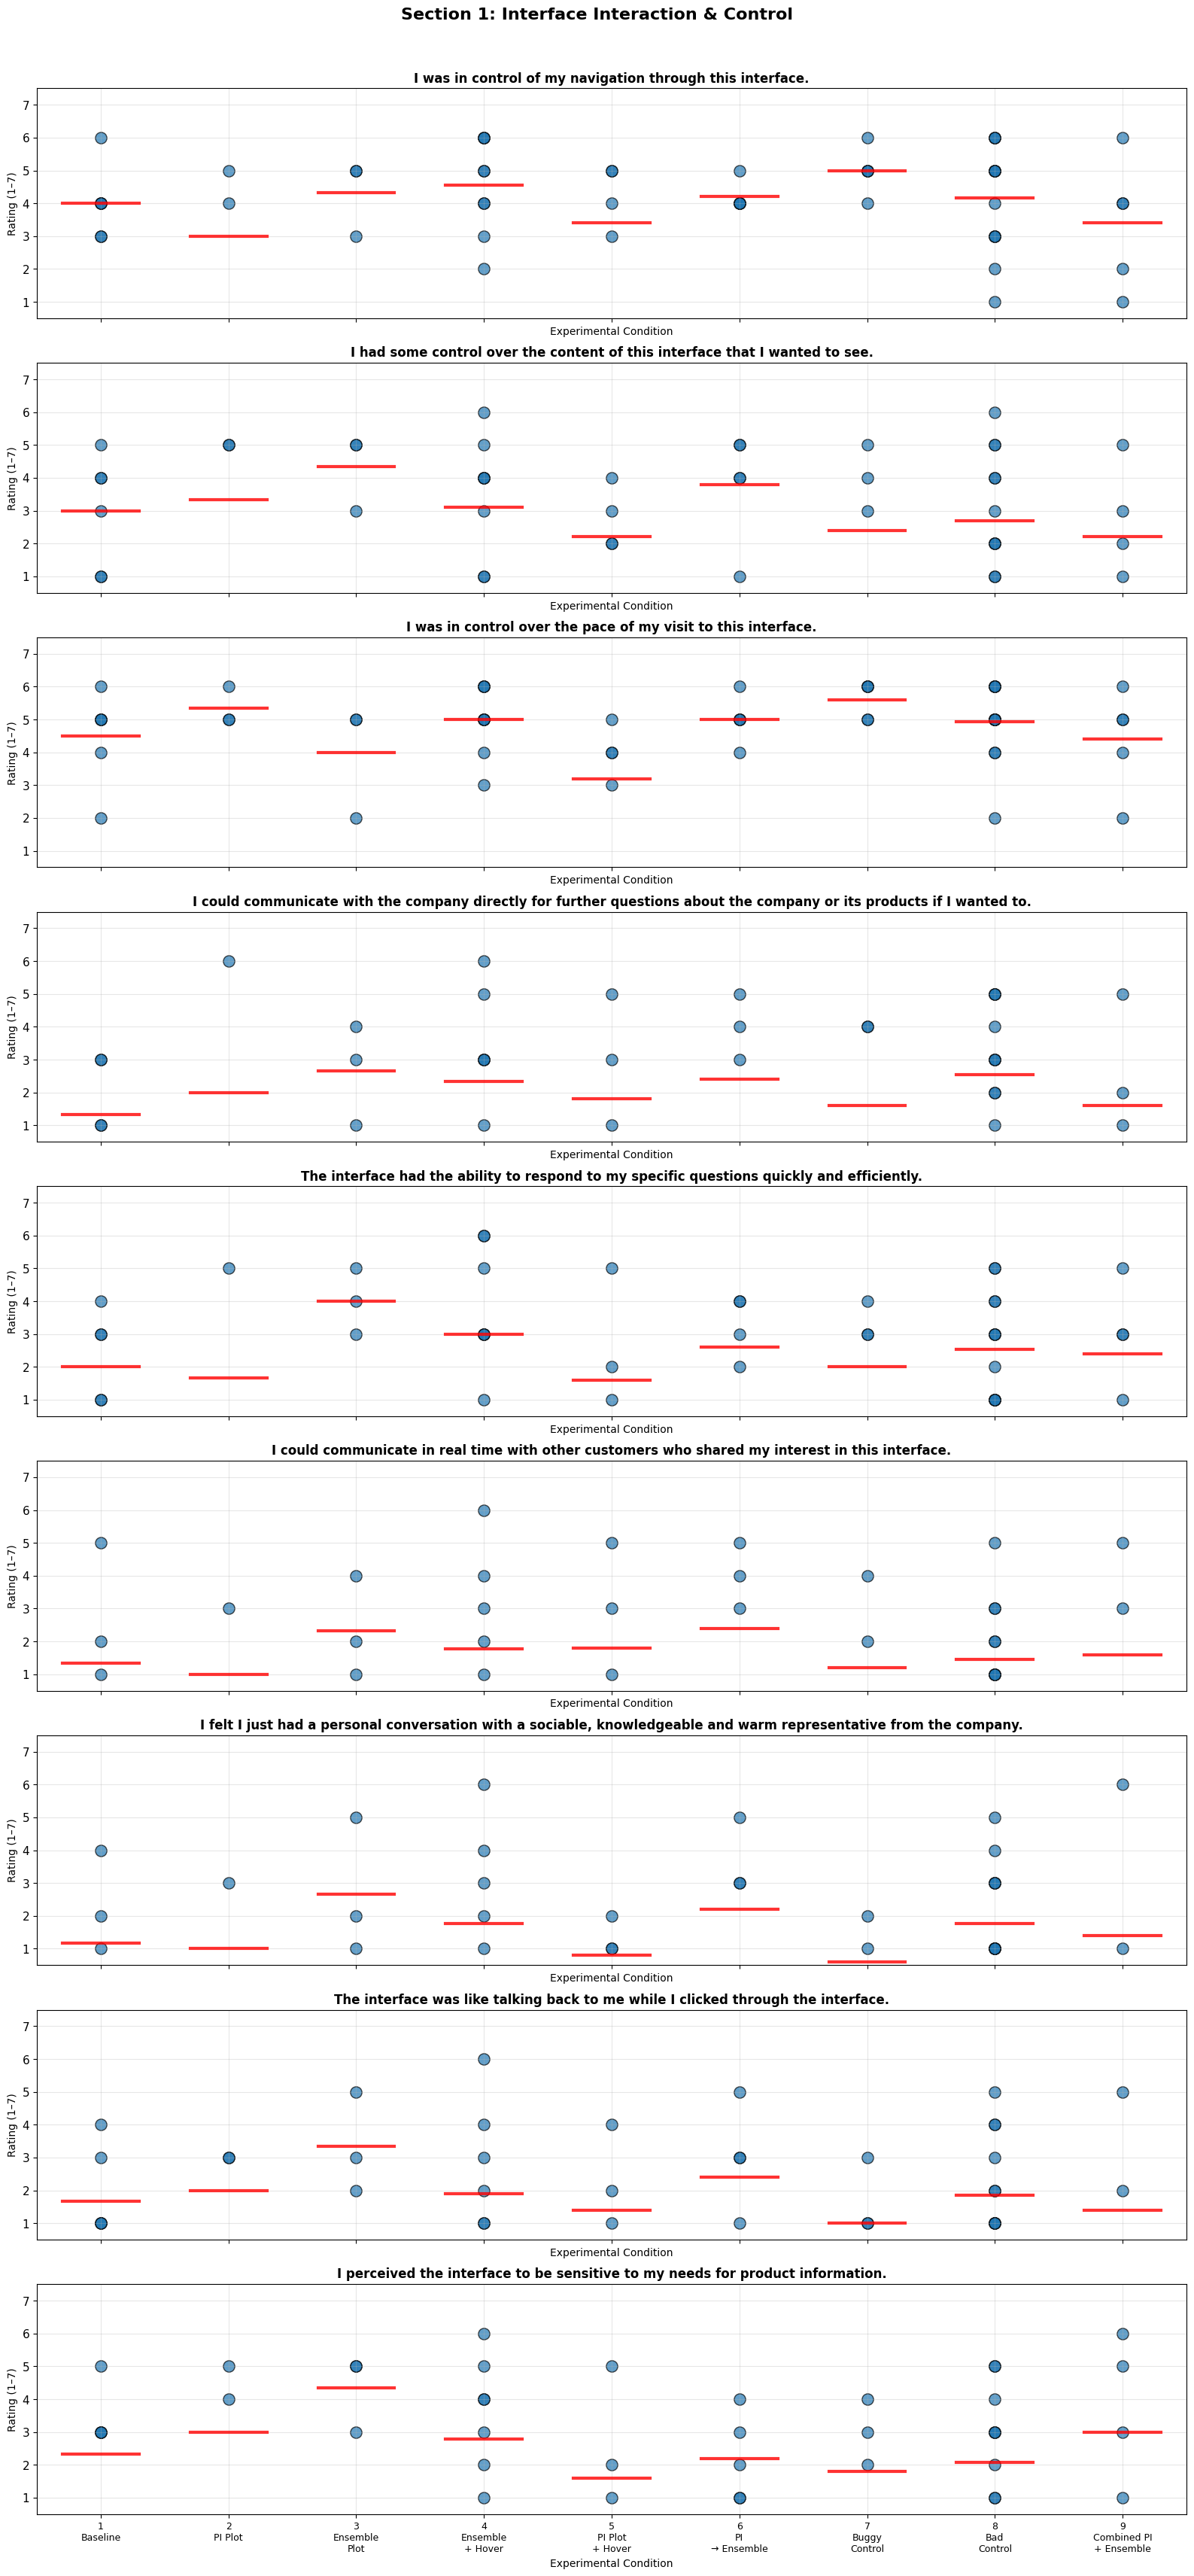


Creating visualization for trust/usability data...


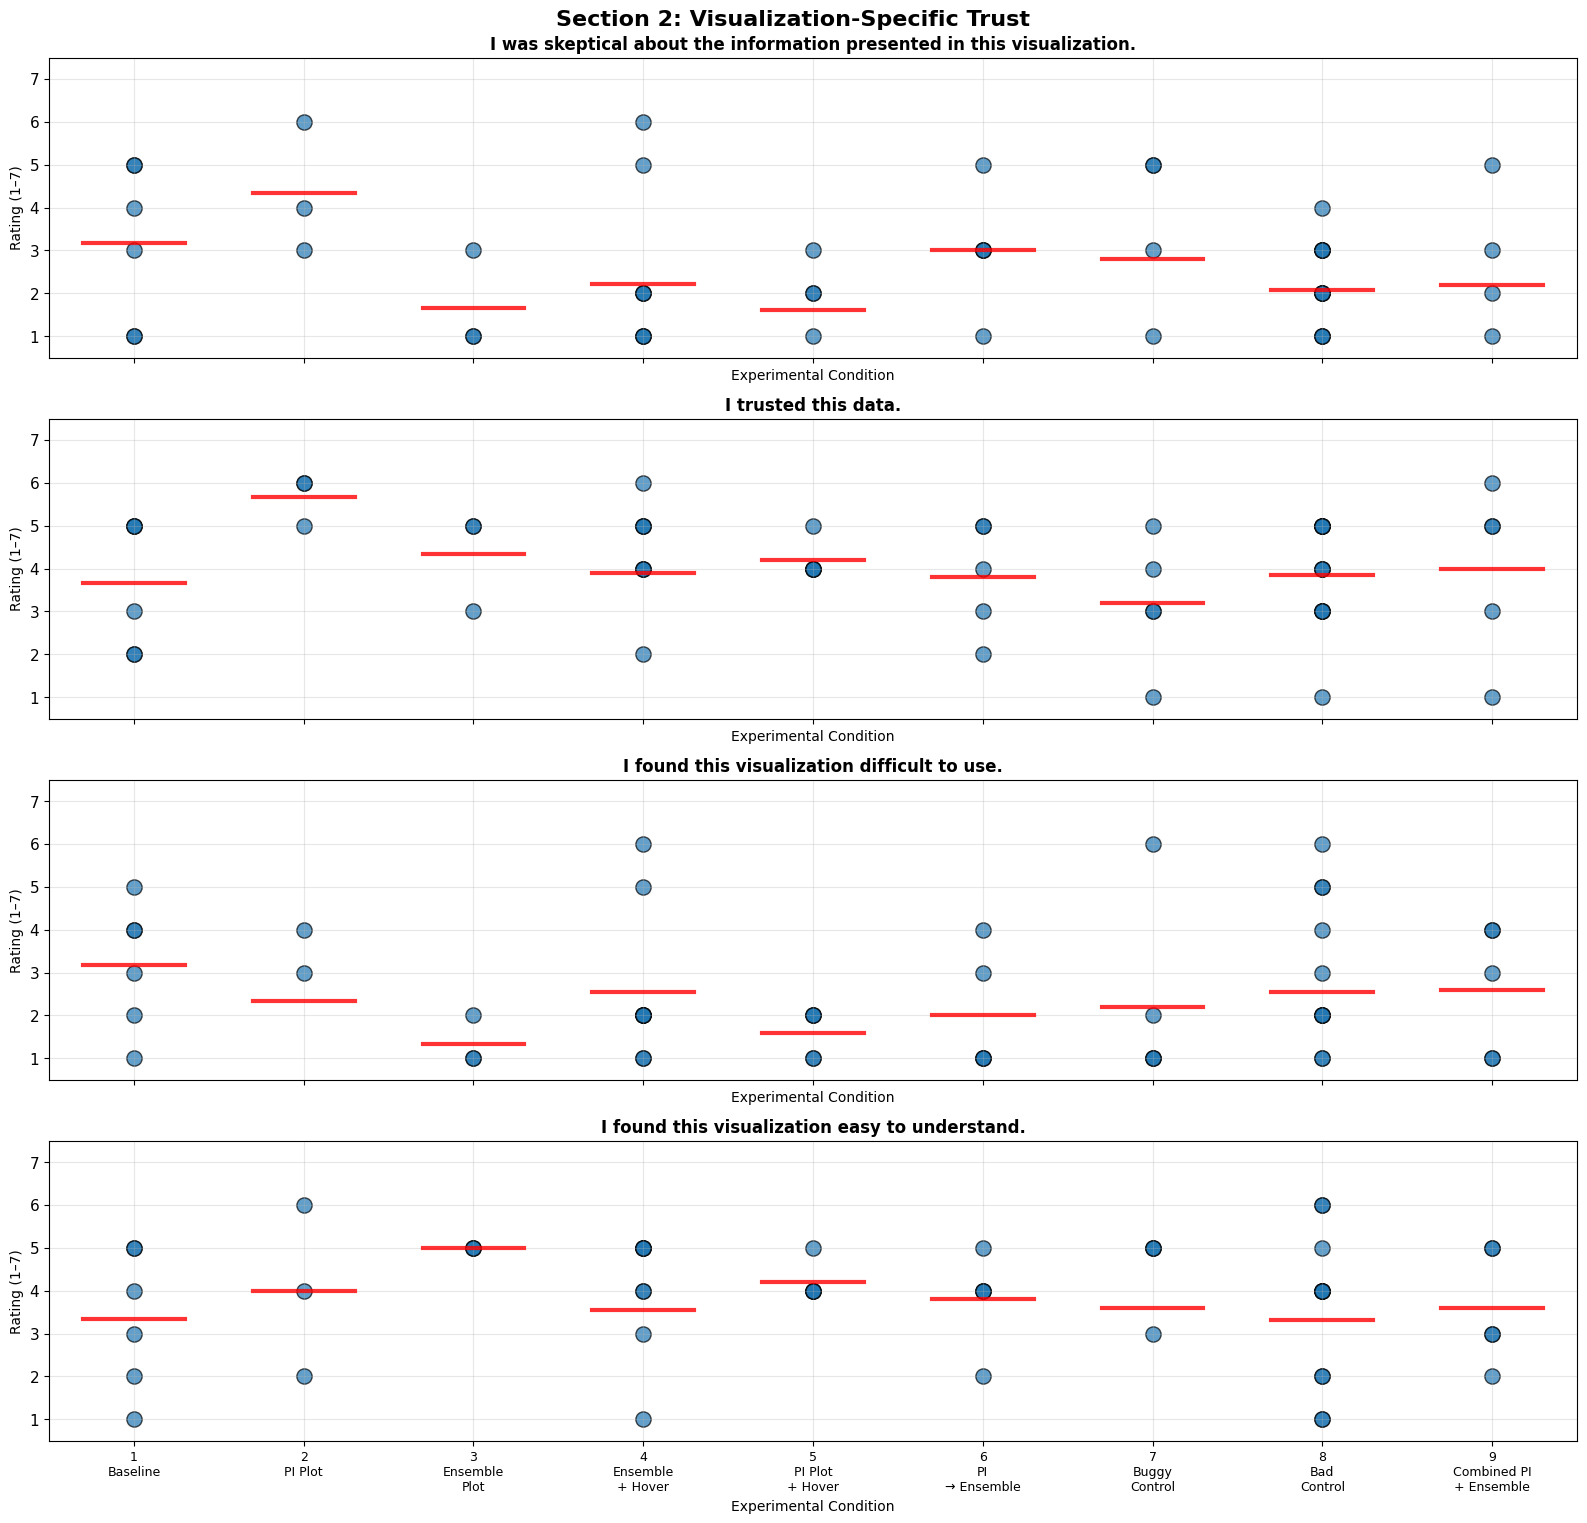

In [434]:
# Generate three separate visualizations for each data type
condition_names = {
    0: "Historical Only",
    1: "Baseline", 
    2: "PI Plot",
    3: "Ensemble Plot",
    4: "Ensemble + Hover", 
    5: "PI Plot + Hover",
    6: "PI → Ensemble",
    7: "Buggy Control",
    8: "Bad Control",
    9: "Combined PI + Ensemble"
}

# Create visualization for interaction data
print("Creating visualization for interface interaction data...")
create_sectioned_trust_plots(
    data=interaction_data,
    condition_names=condition_names,
    questions=interactionQuestions,
    section_title="Section 1: Interface Interaction & Control"
)

# Create visualization for trust data  
print("\nCreating visualization for trust/usability data...")
create_sectioned_trust_plots(
    data=trust_data,
    condition_names=condition_names,
    questions=visualizationTrustQuestions,
    section_title="Section 2: Visualization-Specific Trust"
)

In [435]:
# Calculate averaged interaction scores by condition
import numpy as np
from scipy import stats

# Define interaction question columns
interaction_cols = ['navigation_control', 'content_control', 'pace_control', 
                   'company_communication', 'interface_responsiveness', 
                   'customer_communication', 'personal_conversation', 
                   'interface_interaction', 'interface_sensitivity']

print("=== INTERACTION SCORES BY CONDITION ===")
print("\nCalculating averaged interaction scores (1-7 scale)...")

# Calculate average interaction scores for each participant
interaction_results = []

for _, row in interaction_data.iterrows():
    condition_id = row['condition_id']
    
    # Extract condition number
    try:
        condition_num = int(str(condition_id).split('_')[1])
    except:
        continue
        
    if condition_num == 0:  # Skip condition 0
        continue
    
    # Get all interaction scores for this participant
    scores = []
    for col in interaction_cols:
        if col in row and pd.notna(row[col]):
            scores.append(row[col])
    
    if len(scores) > 0:
        avg_score = np.mean(scores)
        interaction_results.append({
            'condition_id': condition_id,
            'condition_num': condition_num,
            'participant_id': row['participant_id'],
            'avg_interaction_score': avg_score,
            'num_questions': len(scores)
        })

# Convert to DataFrame
results_df = pd.DataFrame(interaction_results)

if len(results_df) > 0:
    # Calculate statistics by condition
    condition_stats = results_df.groupby('condition_num').agg({
        'avg_interaction_score': ['mean', 'std', 'count'],
        'condition_id': 'first'  # Get the condition ID for reference
    }).round(3)
    
    # Flatten column names
    condition_stats.columns = ['mean_score', 'std_score', 'n_participants', 'condition_id']
    
    # Calculate standard error
    condition_stats['se_score'] = (condition_stats['std_score'] / 
                                  np.sqrt(condition_stats['n_participants'])).round(3)
    
    # Add condition names
    condition_names = {
        1: "Baseline", 
        2: "PI Plot",
        3: "Ensemble Plot",
        4: "Ensemble + Hover", 
        5: "PI Plot + Hover",
        6: "PI → Ensemble",
        7: "Buggy Control",
        8: "Bad Control",
        9: "Combined PI + Ensemble"
    }
    
    condition_stats['condition_name'] = condition_stats.index.map(condition_names)
    
    # Sort by mean score (high to low)
    condition_stats_ranked = condition_stats.sort_values('mean_score', ascending=False)
    
    print("\n=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===")
    print("Format: Condition | Mean ± SE | (n participants)")
    print("-" * 65)
    
    for rank, (condition_num, row) in enumerate(condition_stats_ranked.iterrows(), 1):
        condition_name = row['condition_name']
        mean_score = row['mean_score']
        se_score = row['se_score']
        n = int(row['n_participants'])
        
        print(f"{rank:2d}. Condition {condition_num} ({condition_name:18s}) | "
              f"{mean_score:.2f} ± {se_score:.2f} | (n={n})")
    
    # Display detailed breakdown
    print(f"\n=== DETAILED STATISTICS ===")
    display_cols = ['condition_name', 'mean_score', 'std_score', 'se_score', 'n_participants']
    detailed_stats = condition_stats_ranked[display_cols].copy()
    detailed_stats.index.name = 'Condition'
    print(detailed_stats.to_string())
    
    # Show individual participant scores for verification
    print(f"\n=== INDIVIDUAL PARTICIPANT SCORES ===")
    for condition_num in sorted(condition_stats_ranked.index):
        condition_name = condition_names.get(condition_num, "Unknown")
        participant_scores = results_df[results_df['condition_num'] == condition_num]['avg_interaction_score'].tolist()
        print(f"Condition {condition_num} ({condition_name}): {participant_scores}")
    
else:
    print("No interaction data found for analysis")

=== INTERACTION SCORES BY CONDITION ===

Calculating averaged interaction scores (1-7 scale)...

=== INTERACTION SCORES RANKED BY CONDITION (High to Low) ===
Format: Condition | Mean ± SE | (n participants)
-----------------------------------------------------------------
 1. Condition 3 (Ensemble Plot     ) | 3.56 ± 0.63 | (n=3)
 2. Condition 6 (PI → Ensemble     ) | 3.02 ± 0.60 | (n=5)
 3. Condition 4 (Ensemble + Hover  ) | 2.91 ± 0.48 | (n=9)
 4. Condition 8 (Bad Control       ) | 2.67 ± 0.33 | (n=13)
 5. Condition 2 (PI Plot           ) | 2.48 ± 1.12 | (n=3)
 6. Condition 9 (Combined PI + Ensemble) | 2.38 ± 0.77 | (n=5)
 7. Condition 1 (Baseline          ) | 2.37 ± 0.46 | (n=6)
 8. Condition 7 (Buggy Control     ) | 2.36 ± 0.46 | (n=5)
 9. Condition 5 (PI Plot + Hover   ) | 1.98 ± 0.75 | (n=5)

=== DETAILED STATISTICS ===
                   condition_name  mean_score  std_score  se_score  n_participants
Condition                                                                      

In [436]:
# Calculate Phase 2 probability estimates and AQI estimates by condition
import numpy as np

print("=== PHASE 2 PREDICTION ESTIMATES BY CONDITION ===")
print("\nCalculating probability estimates and AQI estimates from Phase 2 data...")

# Calculate prediction estimates for each participant in Phase 2
prediction_results = []

for _, row in phase2_data.iterrows():
    condition_id = row['condition_id']
    
    # Extract condition number
    try:
        condition_num = int(str(condition_id).split('_')[1])
    except:
        continue
        
    if condition_num == 0:  # Skip condition 0 (historical only)
        continue
    
    # Get prediction estimates
    probability_est = row.get('probability_estimate')
    city_a_est = row.get('city_a_estimate') 
    city_b_est = row.get('city_b_estimate')
    confidence = row.get('confidence_rating')
    
    if pd.notna(probability_est):  # At minimum need probability estimate
        prediction_results.append({
            'condition_id': condition_id,
            'condition_num': condition_num,
            'participant_id': row['participant_id'],
            'probability_estimate': probability_est,
            'city_a_estimate': city_a_est if pd.notna(city_a_est) else None,
            'city_b_estimate': city_b_est if pd.notna(city_b_est) else None,
            'confidence_rating': confidence if pd.notna(confidence) else None
        })

# Convert to DataFrame
pred_results_df = pd.DataFrame(prediction_results)

if len(pred_results_df) > 0:
    # Calculate statistics by condition for each measure
    print("\n=== PROBABILITY ESTIMATES (City A > City B) ===")
    prob_stats = pred_results_df.groupby('condition_num').agg({
        'probability_estimate': ['mean', 'std', 'count'],
        'condition_id': 'first'
    }).round(2)
    prob_stats.columns = ['mean_prob', 'std_prob', 'n_prob', 'condition_id']
    prob_stats['se_prob'] = (prob_stats['std_prob'] / np.sqrt(prob_stats['n_prob'])).round(2)
    
    # City A estimates
    print("\n=== CITY A AQI ESTIMATES ===") 
    city_a_data = pred_results_df[pred_results_df['city_a_estimate'].notna()]
    if len(city_a_data) > 0:
        city_a_stats = city_a_data.groupby('condition_num').agg({
            'city_a_estimate': ['mean', 'std', 'count'],
            'condition_id': 'first'
        }).round(2)
        city_a_stats.columns = ['mean_city_a', 'std_city_a', 'n_city_a', 'condition_id']
        city_a_stats['se_city_a'] = (city_a_stats['std_city_a'] / np.sqrt(city_a_stats['n_city_a'])).round(2)
    else:
        city_a_stats = pd.DataFrame()
    
    # City B estimates  
    print("\n=== CITY B AQI ESTIMATES ===")
    city_b_data = pred_results_df[pred_results_df['city_b_estimate'].notna()]
    if len(city_b_data) > 0:
        city_b_stats = city_b_data.groupby('condition_num').agg({
            'city_b_estimate': ['mean', 'std', 'count'], 
            'condition_id': 'first'
        }).round(2)
        city_b_stats.columns = ['mean_city_b', 'std_city_b', 'n_city_b', 'condition_id']
        city_b_stats['se_city_b'] = (city_b_stats['std_city_b'] / np.sqrt(city_b_stats['n_city_b'])).round(2)
    else:
        city_b_stats = pd.DataFrame()
    
    # Combine all statistics
    combined_stats = prob_stats.copy()
    if not city_a_stats.empty:
        combined_stats = combined_stats.join(city_a_stats[['mean_city_a', 'se_city_a', 'n_city_a']], how='left')
    if not city_b_stats.empty:
        combined_stats = combined_stats.join(city_b_stats[['mean_city_b', 'se_city_b', 'n_city_b']], how='left')
    
    # Add condition names
    condition_names = {
        1: "Baseline", 
        2: "PI Plot",
        3: "Ensemble Plot",
        4: "Ensemble + Hover", 
        5: "PI Plot + Hover",
        6: "PI → Ensemble",
        7: "Buggy Control",
        8: "Bad Control",
        9: "Combined PI + Ensemble"
    }
    combined_stats['condition_name'] = combined_stats.index.map(condition_names)
    
    # Sort by probability estimate (LOW to HIGH - lower probability ranked higher)
    combined_stats_ranked = combined_stats.sort_values('mean_prob', ascending=True)
    
    print("\n" + "="*80)
    print("PHASE 2 PREDICTION ESTIMATES RANKED BY PROBABILITY (Low to High)")
    print("="*80)
    print("Format: Condition | P(City A > City B) | City A AQI | City B AQI | (n)")
    print("-" * 80)
    
    for rank, (condition_num, row) in enumerate(combined_stats_ranked.iterrows(), 1):
        condition_name = row['condition_name']
        
        # Probability estimate
        prob_mean = row['mean_prob']
        prob_se = row['se_prob']
        n_prob = int(row['n_prob'])
        
        # City A estimate
        if pd.notna(row.get('mean_city_a')):
            city_a_mean = row['mean_city_a']
            city_a_se = row['se_city_a']
            city_a_str = f"{city_a_mean:.1f} ± {city_a_se:.1f}"
        else:
            city_a_str = "N/A"
        
        # City B estimate  
        if pd.notna(row.get('mean_city_b')):
            city_b_mean = row['mean_city_b']
            city_b_se = row['se_city_b']
            city_b_str = f"{city_b_mean:.1f} ± {city_b_se:.1f}"
        else:
            city_b_str = "N/A"
        
        print(f"{rank:2d}. Condition {condition_num} ({condition_name:18s}) | "
              f"{prob_mean:5.1f}% ± {prob_se:4.1f} | {city_a_str:>12s} | {city_b_str:>12s} | (n={n_prob})")
    
    # Detailed breakdown
    print(f"\n" + "="*60)
    print("DETAILED STATISTICS TABLE")
    print("="*60)
    display_cols = ['condition_name', 'mean_prob', 'se_prob', 'n_prob']
    if not city_a_stats.empty:
        display_cols.extend(['mean_city_a', 'se_city_a'])
    if not city_b_stats.empty:
        display_cols.extend(['mean_city_b', 'se_city_b'])
    
    detailed_pred_stats = combined_stats_ranked[display_cols].copy()
    detailed_pred_stats.index.name = 'Condition'
    print(detailed_pred_stats.to_string())
    
    # Individual participant data for verification
    print(f"\n" + "="*60)
    print("INDIVIDUAL PARTICIPANT ESTIMATES")
    print("="*60)
    for condition_num in sorted(combined_stats_ranked.index):
        condition_name = condition_names.get(condition_num, "Unknown")
        condition_data = pred_results_df[pred_results_df['condition_num'] == condition_num]
        
        prob_values = condition_data['probability_estimate'].tolist()
        city_a_values = condition_data['city_a_estimate'].dropna().tolist()
        city_b_values = condition_data['city_b_estimate'].dropna().tolist()
        
        print(f"\nCondition {condition_num} ({condition_name}):")
        print(f"  Probability estimates: {prob_values}")
        if city_a_values:
            print(f"  City A AQI estimates: {city_a_values}")
        if city_b_values:
            print(f"  City B AQI estimates: {city_b_values}")
    
else:
    print("No Phase 2 prediction data found for analysis")

=== PHASE 2 PREDICTION ESTIMATES BY CONDITION ===

Calculating probability estimates and AQI estimates from Phase 2 data...

=== PROBABILITY ESTIMATES (City A > City B) ===

=== CITY A AQI ESTIMATES ===

=== CITY B AQI ESTIMATES ===

PHASE 2 PREDICTION ESTIMATES RANKED BY PROBABILITY (Low to High)
Format: Condition | P(City A > City B) | City A AQI | City B AQI | (n)
--------------------------------------------------------------------------------
 1. Condition 6 (PI → Ensemble     ) |  22.6% ± 10.3 |   91.0 ± 3.3 |   92.8 ± 3.9 | (n=5)
 2. Condition 8 (Bad Control       ) |  37.8% ±  9.3 |   88.5 ± 5.0 |   97.4 ± 2.5 | (n=13)
 3. Condition 2 (PI Plot           ) |  40.0% ± 30.6 |   94.3 ± 1.8 |   99.0 ± 2.1 | (n=3)
 4. Condition 9 (Combined PI + Ensemble) |  44.8% ± 14.3 |   86.4 ± 6.7 |  88.8 ± 12.3 | (n=5)
 5. Condition 4 (Ensemble + Hover  ) |  46.0% ± 14.0 |   95.3 ± 1.5 |   99.9 ± 1.2 | (n=9)
 6. Condition 7 (Buggy Control     ) |  49.2% ± 20.1 |  76.0 ± 14.9 |  76.8 ± 18.3 | (n=5

![alt text](SCR-20251208-ovoi-1.png)